In [56]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import sys
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# Recall y precision
from reco_utils.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation


print("System version: {}".format(sys.version))
print("Spark version: {}".format(pyspark.__version__))

System version: 3.9.5 (default, May 18 2021, 12:31:01) 
[Clang 10.0.0 ]
Spark version: 3.1.2


In [2]:
path='./DATA'
file = os.path.join(path, "users_bgs.csv")

In [3]:
df=pd.read_csv(file, usecols=['u_id','bgg_id','Game','category','Your Rating'], low_memory=False)
df.head()

,u_id,Game,Your Rating,bgg_id,category
0,0,1830: Railways & Robber Barons,-1,421,"1021,1034,1011"
1,0,18AL,7,2612,"1021,1120,1034,1011"
2,0,2 de Mayo,6,36522,"1051,1019"
3,0,23,7,103651,1002
4,0,6 nimmt!,7,432,"1002,1098"


In [4]:
#Transform explicit values to implicit values
df['Rating'] = df['Your Rating'].apply(lambda x: 1 if x>0 else 0)

#### Remove users who only have one board game

In [5]:
#Group by 'user_id'
p=df.groupby('u_id').count()

In [6]:
# Visualise users with a single board game
(p['bgg_id']==1).sum()

6

In [7]:
# Remove the user_id with a single board game
bgu=list(p[p['bgg_id']==1].index)

dfm = df[~df.u_id.isin(bgu)]

#### Modified the id of games and users so that they are correlative

In [8]:
# Create a dictionary for games titles and ids

bgg_id=list(dfm['bgg_id'])
game=list(dfm['Game'])

item_dict={}

for key in bgg_id:
    for value in game:
        item_dict[key] = value
        game.remove(value)
        break 

In [9]:
print(len(set(item_dict.keys())))
print(len(set(item_dict.values())))

36535
36535


In [10]:
# Resample
resample_id_item_dict={}
for index, key in enumerate(item_dict.keys()):
    resample_id_item_dict[key]= index
    

In [11]:
resample_item_dict = {resample_id_item_dict[k]:v for k,v in item_dict.items()}
assert(len(set(resample_item_dict.keys())) == len(set(resample_item_dict.values())))

In [12]:
# Create a dictionary for resample users id

u_id=list(dfm['u_id'].unique())
resample_user_dict={}

for index,key in enumerate(u_id):
    resample_user_dict[key] = index

In [13]:
print(len(set(resample_user_dict.keys())))
print(len(set(resample_user_dict.values())))

2844
2844


In [14]:
# Copy and apply the changes
dfm_r=dfm.copy()
dfm_r['item_id']=dfm['bgg_id'].apply(lambda x: resample_id_item_dict[x])
dfm_r['user_id']=dfm['u_id'].apply(lambda x: resample_user_dict[x])
dfm_r.describe()

,u_id,Your Rating,bgg_id,Rating,item_id,user_id
count,838777.000000,838777.000000,838777.000000,838777.000000,838777.000000,838777.000000
mean,1404.570457,3.423040,91310.618300,0.545138,4722.867555,1403.031329
std,813.788285,4.159144,88829.182464,0.497959,6316.864111,812.113149
min,0.000000,-1.000000,1.000000,0.000000,0.000000,0.000000
25%,700.000000,-1.000000,9209.000000,0.000000,680.000000,700.000000
50%,1375.000000,5.000000,55952.000000,1.000000,2185.000000,1374.000000
75%,2087.000000,7.000000,163976.000000,1.000000,6332.000000,2086.000000
max,2851.000000,10.000000,332853.000000,1.000000,36534.000000,2843.000000


In [15]:
#dfm_r.to_csv('DATA/r_users_bgs.csv')
#path='./DATA'
#file = os.path.join(path, "r_users_bgs.csv")
#dfm_r=pd.read_csv(file, low_memory=False)
#dfm_r.head()

#### Format Data for models

In [16]:

dfratings = pd.DataFrame()

dfratings['user_id']=dfm_r['user_id']
dfratings['item_id']=dfm_r['item_id']
dfratings['rating']=dfm_r['Rating']

print(dfratings.shape)
dfratings.head()

(838777, 3)


,user_id,item_id,rating
0,0,0,0
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


In [17]:
dfbg = dfm_r.groupby(by=['bgg_id','category'], as_index=False).first()
dfbg.drop(['bgg_id','u_id','Your Rating','Rating', 'user_id'],axis=1, inplace=True)

In [19]:
dfgames = pd.DataFrame()

dfgames['item_id']=dfbg['item_id']
dfgames['title']=dfbg['Game']
dfgames['category']=dfbg['category']

print(dfgames.shape)
dfgames.head()

(36535, 3)


,item_id,title,category
0,747,Die Macher,"1021,1026,1001"
1,5896,Dragonmaster,"1002,1010"
2,292,Samurai,"1009,1035"
3,6308,Tal der Könige,1050
4,15364,Mare Mediterraneum,"1015,1008"


## Content Based

In [19]:
# ----- COMENTARIO

In [75]:
df_games=dfgames.copy()

In [76]:
df_games['category'] = df_games['category'].map(lambda x: x.replace(',', ' '))
print(dfgames['category'])

0        1021,1026,1001
1             1002,1010
2             1009,1035
3                  1050
4             1015,1008
              ...      
36530              1002
36531         1002,1030
36532         1002,2481
36533    1009,1028,1113
36534         1021,1013
Name: category, Length: 36535, dtype: object


In [77]:
df_games.set_index('title', inplace = True)
df_games.head()

,item_id,category
title,,
Die Macher,747,1021 1026 1001
Dragonmaster,5896,1002 1010
Samurai,292,1009 1035
Tal der Könige,6308,1050
Mare Mediterraneum,15364,1015 1008


In [78]:
print(np.where(df_games.index=='Tal der Könige')[0])

[3]


In [79]:
count = CountVectorizer()
count_matrix = count.fit_transform(df_games['category'])

In [80]:
cosine = cosine_similarity(count_matrix, count_matrix)
cosine

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.40824829],
       [0.        , 1.        , 0.        , ..., 0.5       , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.40824829,
        0.        ],
       ...,
       [0.        , 0.5       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.40824829, ..., 0.        , 1.        ,
        0.        ],
       [0.40824829, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [81]:
def cb_recommendations(name, cosine = cosine):
    
    recommended = []
    indices = pd.Series(df_games.index)
    idx = indices[indices == name].index[0]
    score = pd.Series(cosine[idx]).sort_values(ascending = False)
    top_10 = list(score.iloc[0:11].index)
    for i in top_10:
        if idx != i:
            recommended.append(list(df_games.index)[i])
        
    return recommended

In [83]:
cb_recommendations('Azul')

['Rennaissance Chess',
 'Azul: Stained Glass of Sintra',
 'Three Musketeers Game: Chess Variant',
 'Jaleo',
 'Blinq',
 'Spark',
 'Interplay',
 '0·1 (Zero Point One)',
 'Genial Spezial',
 'Color Wheel']

In [31]:
## Collaborative Filtering

In [32]:
#Split random into training and test datasets
train, test = train_test_split(dfratings, test_size = 0.20, random_state = 42) 

In [33]:
print('There are %s users, %s itmes and %s pairs in the train set' \
      %(train.user_id.unique().shape[0], train.item_id.unique().shape[0], train.shape[0]))
train.head()

There are 2844 users, 34067 itmes and 671021 pairs in the train set


,user_id,item_id,rating
32330,123,1060,0
399743,1313,1287,1
763101,2564,5918,0
79614,259,1340,1
719436,2418,727,1


In [34]:
print('There are %s users, %s itmes and %s pairs in the test set' \
      %(test.user_id.unique().shape[0], test.item_id.unique().shape[0], test.shape[0]))
test.head()

There are 2838 users, 20894 itmes and 167756 pairs in the test set


,user_id,item_id,rating
332615,1114,1151,1
489596,1619,2907,1
499690,1659,647,1
698079,2334,1283,1
288796,963,7547,1


In [35]:
### Popularity

In [36]:
# group the train dataset by item and count the number of users
popular = train.groupby('item_id')['user_id'].count()

In [37]:
popular.head()

item_id
0    294
1     74
2    157
3     65
4    798
Name: user_id, dtype: int64

In [38]:
# Sort in descending order
popularsort = popular.sort_values(ascending=False)

In [39]:
popularsort.shape[0]

34067

In [40]:
popularsort.head()

item_id
51     1322
195    1296
70     1262
242    1179
55     1171
Name: user_id, dtype: int64

In [41]:
popularsort.index #id of the Board Game

Int64Index([   51,   195,    70,   242,    55,     5,    44,    15,    93,
              256,
            ...
            27193, 14744, 27180, 27181, 27182, 27183, 27185, 27188, 27190,
            36533],
           dtype='int64', name='item_id', length=34067)

In [42]:
popularbg = np.zeros(shape=(popularsort.shape[0], 3), dtype=object) #MODIFICAR ESTE NOMBRE

for i, ind in enumerate(popularsort.index):
    idx = ind 
    freq = popularsort[idx]  
    title = resample_item_dict[idx]
    popularbg[i] = [idx, title, freq]
    

In [43]:
popularbg[:10,:]

array([[51, 'Carcassonne', 1322],
       [195, 'Love Letter', 1296],
       [70, 'Codenames', 1262],
       [242, 'Pandemic', 1179],
       [55, 'Catan', 1171],
       [5, '7 Wonders', 1160],
       [44, 'Bohnanza', 1155],
       [15, 'Agricola', 1129],
       [93, 'Dominion', 1113],
       [256, 'Power Grid', 1062]], dtype=object)

In [44]:
# Recall
def recall_at_n(N, test, recommended, train=None):
    """
    :param N: number of recommendations
    :param test: list of movies seen by user in test
    :param train: list of movies seen by user in train. This has to be removed from the recommended list 
    :param recommended: list of movies recommended
    
    :return the recall
    """
    if train is not None: 
        
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
    else:
        rec_true = recommended    
    intersection = len(set(test) & set(rec_true[:N]))
    return intersection / float(np.minimum(N, len(test)))

In [45]:
# get movies in train per user. For this, group by user and get a list of item ids.
trainUsergby = (train.groupby('user_id')['item_id'].apply(list).reset_index())

In [46]:
trainUsergby.head()

,user_id,item_id
0,0,"[276, 308, 192, 300, 100, 6, 391, 388, 287, 10..."
1,1,"[513, 411, 258, 650, 615, 294, 202, 77, 171, 6..."
2,2,"[791, 751, 360, 795, 629, 799, 763, 758, 725, ..."
3,3,"[823, 409, 157, 5, 369, 843, 591, 876, 877, 84..."
4,4,"[375, 903, 941, 939, 227, 957, 232, 947, 148, ..."


In [47]:
testUsergby = (test.groupby('user_id')['item_id'].apply(list).reset_index())
testUsergby.head()

,user_id,item_id
0,0,"[158, 317, 31, 122, 167, 63, 43, 18, 327, 256,..."
1,1,"[548, 661, 578, 276, 611, 544, 454, 472, 689, ..."
2,2,"[163, 768, 157, 329, 346, 802, 781, 797, 455, ..."
3,3,"[870, 155, 824, 432, 599, 888, 829, 156, 868, ..."
4,4,"[893, 479, 325, 944, 959, 951, 361, 917, 922, ..."


In [48]:
# Merge both df
joinedtt = pd.merge(trainUsergby, testUsergby, how='inner', on='user_id', suffixes=('_train', '_test'))
joinedtt.head()

,user_id,item_id_train,item_id_test
0,0,"[276, 308, 192, 300, 100, 6, 391, 388, 287, 10...","[158, 317, 31, 122, 167, 63, 43, 18, 327, 256,..."
1,1,"[513, 411, 258, 650, 615, 294, 202, 77, 171, 6...","[548, 661, 578, 276, 611, 544, 454, 472, 689, ..."
2,2,"[791, 751, 360, 795, 629, 799, 763, 758, 725, ...","[163, 768, 157, 329, 346, 802, 781, 797, 455, ..."
3,3,"[823, 409, 157, 5, 369, 843, 591, 876, 877, 84...","[870, 155, 824, 432, 599, 888, 829, 156, 868, ..."
4,4,"[375, 903, 941, 939, 227, 957, 232, 947, 148, ...","[893, 479, 325, 944, 959, 951, 361, 917, 922, ..."


In [49]:
# Evaluate the model for different number of recommended elements 

list_topN=[1,5,10,20]

for topN in list_topN:
    rec=popularbg[:, 0]
    r_u=joinedtt.apply(lambda l: recall_at_n(N=topN, test=l[2], recommended=rec, train=l[1]), axis=1)
    print('TopN:',topN,',','recall: ',r_u.mean())

TopN: 1 , recall:  0.26955602536997886
TopN: 5 , recall:  0.22798919426826403
TopN: 10 , recall:  0.1964032629730304
TopN: 20 , recall:  0.16919690904544024


In [50]:
#MAP
def apk(N, test, recommended, train=None):
    """
    Computes the average precision at N given recommendations.
    
    :param N: number of recommendations
    :param test: list of movies seen by user in test
    :param train: list of movies seen by user in train. This has to be removed from the recommended list 
    :param recommended: list of movies recommended
    
    :return The average precision at N over the test set
    """
    if train is not None: 
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
    else:
        rec_true = recommended    
    predicted = rec_true[:N] # top-k predictions
    
    score = 0.0 # This will store the numerator
    num_hits = 0.0 # This will store the sum of rel(i)

    for i,p in enumerate(predicted):
        if p in test and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits/(i+1.0)

    return score / min(len(test), N)

In [51]:
list_topN=[1,5,10,20]

for topN in list_topN:
    predictions = popularbg[:, 0]
    m = joinedtt.apply(lambda l: apk(topN, l[2], predictions, l[1]), axis=1)
    print('TopN:',topN,',','map: ',m.mean()) #Mejorar impresion

TopN: 1 , map:  0.26955602536997886
TopN: 5 , map:  0.1577572233967583
TopN: 10 , map:  0.11372292258262635
TopN: 20 , map:  0.07998291413267286


In [52]:
## Matrix Co-Ocurrence

In [53]:
moviesPerUser = (train.groupby('user_id')['item_id']
                 .apply(np.array)
                 .to_dict()
                 )

In [54]:
# calculate the number of items in train
n_items = len(resample_item_dict.keys())
n_items

36535

In [55]:
# co-ocurrance matrix will have shape=[n_items,n_items]
coMatrix = np.zeros((n_items, n_items)) # co-occurrence matrix
for user,movies in moviesPerUser.items():
    for m in movies:
        coMatrix[m, movies] += 1

In [56]:
coMatrix

array([[294.,  42.,  35., ...,   0.,   0.,   0.],
       [ 42.,  74.,  10., ...,   0.,   0.,   0.],
       [ 35.,  10., 157., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   1.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

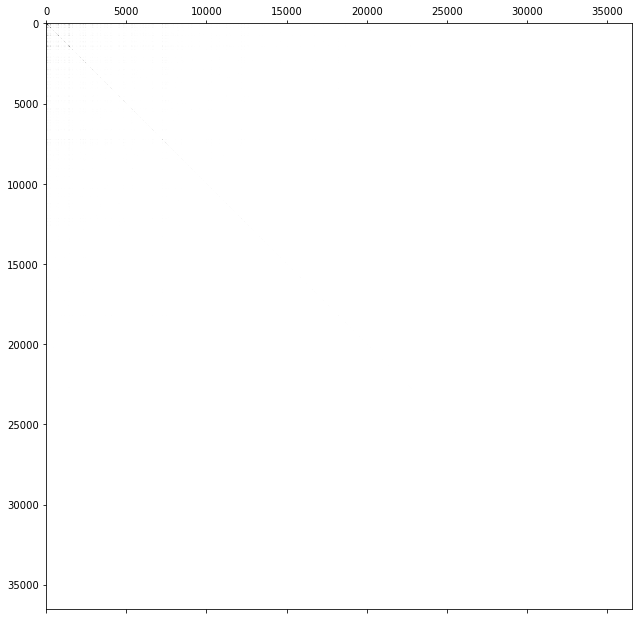

In [57]:
# visualize the matrix
plt.matshow(coMatrix, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [58]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):
    """
    Returns the top-N most similar items to a given one, based on the coocurrance matrix
    
    :param item_id: id of input item
    :param cooccurrance: 2-dim numpy array with the co-occurance matrix
    :param ntop: number of items to be retrieved
    
    :return top-N most similar items to the given item_id
    """
    similarItems = coocurrance[item_id, :]
    # return indeces of most similar items in descendign order
    mostSimilar = np.argsort(similarItems)[::-1]
    # remove the first element, as it is the item itslef
    mostSimilar = mostSimilar[1:ntop+1]
    
    # return a numpy array with the index (first column) and the value (second column) of the most similar items
    return np.stack((mostSimilar, similarItems[mostSimilar])).T

In [59]:
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):
    """
    Obtain the list of ntop recommendations based on a list of items (user history of views)
    
    :param items_id: list of items ids
    :param coocurrence: co-ocurrence matrix (numpy 2-dim array)
    :param ntop: top-K items to be retrieved
    
    :return list of ntop items recommended
    """
    # put together all the similar items and its value. For this, use np.vstack, wich stacks one array after 
    # another (row wise)
    list_sim_items = np.vstack([co_occurrance_similarity(id_, cooccurrance, ntop) for id_ in items_id])
    # Group by id and take the maximum frquency to remove duplicates
    largest_freq = pd.DataFrame(list_sim_items, columns=['id', 'freq']).groupby('id').agg(max).reset_index()
    
    # sort by value in descending order
    sorted_list = largest_freq.sort_values(by='freq', ascending=False)
    
    # get the top N
    out = sorted_list.values[:ntop, 0]
    return out

In [60]:
# get users in train with their movies
trainUsersGrouped = train.groupby('user_id')['item_id'].apply(list).reset_index()
trainUsersGrouped.head()

,user_id,item_id
0,0,"[276, 308, 192, 300, 100, 6, 391, 388, 287, 10..."
1,1,"[513, 411, 258, 650, 615, 294, 202, 77, 171, 6..."
2,2,"[791, 751, 360, 795, 629, 799, 763, 758, 725, ..."
3,3,"[823, 409, 157, 5, 369, 843, 591, 876, 877, 84..."
4,4,"[375, 903, 941, 939, 227, 957, 232, 947, 148, ..."


In [61]:
Ntop = 20
# Get the recommendations for all users using the apply method
predictions = trainUsersGrouped.item_id.apply(lambda x: co_occurrance_recommendation(x, coMatrix, Ntop))
predictions.head()

0    [195.0, 55.0, 51.0, 5.0, 70.0, 242.0, 93.0, 44...
1    [195.0, 51.0, 5.0, 70.0, 55.0, 93.0, 242.0, 15...
2    [51.0, 195.0, 70.0, 55.0, 44.0, 5.0, 93.0, 15....
3    [70.0, 55.0, 195.0, 51.0, 5.0, 242.0, 93.0, 44...
4    [70.0, 51.0, 242.0, 5.0, 55.0, 148.0, 195.0, 1...
Name: item_id, dtype: object

In [62]:
# get users in test with their movies
testUsersGrouped = test.groupby('user_id')['item_id'].apply(list).reset_index()
testUsersGrouped.head()

,user_id,item_id
0,0,"[158, 317, 31, 122, 167, 63, 43, 18, 327, 256,..."
1,1,"[548, 661, 578, 276, 611, 544, 454, 472, 689, ..."
2,2,"[163, 768, 157, 329, 346, 802, 781, 797, 455, ..."
3,3,"[870, 155, 824, 432, 599, 888, 829, 156, 868, ..."
4,4,"[893, 479, 325, 944, 959, 951, 361, 917, 922, ..."


In [63]:
for (seen, recom) in zip(testUsersGrouped.values[:5, 1], predictions[:5]):
    print("*"*6)
    print("Seen items: ")
    print([resample_item_dict[i] for i in seen])
    print("Recommended items: ")
    print([resample_item_dict[i] for i in recom]) #QUITAR ELEMENTOS MOSTRADOS

******
Seen items: 
['Homesteaders', 'Star Wars PocketModel TCG', 'Aton', 'Fresco', 'Istanbul', 'Citadels', 'Black Vienna', 'Alchemists', 'T.I.M.E Stories', 'Power Grid', 'Castles of Mad King Ludwig', 'Heads of State', 'Innovation', "Odin's Ravens", 'Chicken Cha Cha Cha', 'Casino Hot Dog', 'A Feast for Odin', 'To Court the King', 'Terraforming Mars', 'Thebes', 'Roads & Boats', 'Progress: Evolution of Technology', "Stick 'Em", 'Relationship Tightrope', 'Mage Knight Board Game', 'Cartographers', "King's Breakfast", 'Wizard', 'Snorta!', 'Halli Galli', 'Machi Koro', 'Felicity: The Cat in the Sack', "The Werewolves of Miller's Hollow", 'Mouse Chaos', "Who's the Ass?", 'Weilong', 'Ora et Labora', 'Richelieu', "Aladdin's Dragons", 'Terra Mystica', 'Labyrinth', 'Super Motherload', 'Great Western Trail', 'No Thanks!', 'Galaxy Trucker', 'Exit: The Game – The Secret Lab', 'Age of Steam', 'For Sale', 'Union Pacific', 'Ground Floor', 'Android: Netrunner', 'Ra', 'The Lord of the Rings: The Fellowshi

In [64]:
topN=30
# add a prediction column to train
trainUsersGrouped['prediction'] = trainUsersGrouped.item_id.apply(
    lambda x: co_occurrance_recommendation(x, coMatrix, topN)
)

In [65]:
trainUsersGrouped.head()

,user_id,item_id,prediction
0,0,"[276, 308, 192, 300, 100, 6, 391, 388, 287, 10...","[195.0, 55.0, 51.0, 5.0, 70.0, 242.0, 93.0, 44..."
1,1,"[513, 411, 258, 650, 615, 294, 202, 77, 171, 6...","[195.0, 51.0, 5.0, 70.0, 55.0, 93.0, 242.0, 15..."
2,2,"[791, 751, 360, 795, 629, 799, 763, 758, 725, ...","[51.0, 195.0, 70.0, 55.0, 44.0, 5.0, 93.0, 15...."
3,3,"[823, 409, 157, 5, 369, 843, 591, 876, 877, 84...","[70.0, 55.0, 195.0, 51.0, 5.0, 242.0, 93.0, 44..."
4,4,"[375, 903, 941, 939, 227, 957, 232, 947, 148, ...","[70.0, 51.0, 242.0, 5.0, 55.0, 148.0, 195.0, 1..."


In [66]:
# Join the df with train and predictions with the test df
joined = pd.merge(trainUsersGrouped, testUsersGrouped, how='inner', on='user_id', suffixes=('_train', '_test'))

In [67]:
joined.head()

,user_id,item_id_train,prediction,item_id_test
0,0,"[276, 308, 192, 300, 100, 6, 391, 388, 287, 10...","[195.0, 55.0, 51.0, 5.0, 70.0, 242.0, 93.0, 44...","[158, 317, 31, 122, 167, 63, 43, 18, 327, 256,..."
1,1,"[513, 411, 258, 650, 615, 294, 202, 77, 171, 6...","[195.0, 51.0, 5.0, 70.0, 55.0, 93.0, 242.0, 15...","[548, 661, 578, 276, 611, 544, 454, 472, 689, ..."
2,2,"[791, 751, 360, 795, 629, 799, 763, 758, 725, ...","[51.0, 195.0, 70.0, 55.0, 44.0, 5.0, 93.0, 15....","[163, 768, 157, 329, 346, 802, 781, 797, 455, ..."
3,3,"[823, 409, 157, 5, 369, 843, 591, 876, 877, 84...","[70.0, 55.0, 195.0, 51.0, 5.0, 242.0, 93.0, 44...","[870, 155, 824, 432, 599, 888, 829, 156, 868, ..."
4,4,"[375, 903, 941, 939, 227, 957, 232, 947, 148, ...","[70.0, 51.0, 242.0, 5.0, 55.0, 148.0, 195.0, 1...","[893, 479, 325, 944, 959, 951, 361, 917, 922, ..."


In [68]:
def evaluate_recall(topN, trainGrouped, testGrouped, coMatrix, popularity_baseline):
    # add a prediction column to train
    trainUsersGrouped['prediction'] = trainUsersGrouped.item_id.apply(
        lambda x: co_occurrance_recommendation(x, coMatrix, topN)
    )
    # join with test data
    joined = pd.merge(trainUsersGrouped, testUsersGrouped, how='inner', on='user_id', suffixes=('_train', '_test'))
    # calculate average recall
    recall = joined.apply(lambda l: 
                 recall_at_n(N=topN, test=l[3], recommended=l[2], train=l[1]), axis=1).mean()
    print("Co-occurance model: recall@%s=%.3f"%(topN, recall))
    # calculate average recall for the baseline
    recall_baseline = joined.apply(lambda l: 
                 recall_at_n(N=topN, test=l[3], recommended=popularity_baseline, train=l[1]), axis=1).mean()
    print("Popularity model: recall@%s=%.3f"%(topN, recall_baseline))    
    return recall, recall_baseline

In [69]:
for k in [5,10,20,30]:
    evaluate_recall(k, trainUsersGrouped, testUsersGrouped, coMatrix, popularbg[:, 0]);

Co-occurance model: recall@5=0.114
Popularity model: recall@5=0.228
Co-occurance model: recall@10=0.107
Popularity model: recall@10=0.196
Co-occurance model: recall@20=0.107
Popularity model: recall@20=0.169
Co-occurance model: recall@30=0.110
Popularity model: recall@30=0.163


In [70]:
## CF ALS

In [57]:
#Create a spark session
spark = SparkSession.builder.getOrCreate()

In [58]:
#Load data

schema = StructType(
    (
        StructField("user_id", IntegerType()),
        StructField("item_id", IntegerType()),
        StructField("rating", IntegerType()),
    )
)

df_ratings = spark.createDataFrame(dfratings, schema=schema)
df_ratings.show(5)

schema = StructType(
    (
        StructField("item_id", IntegerType()),
        StructField("title", StringType()),
        StructField("category", StringType()),
    )
)


df_games = spark.createDataFrame(dfgames, schema=schema)
df_games.show(5, False)


+-------+-------+------+
|user_id|item_id|rating|
+-------+-------+------+
|      0|      0|     0|
|      0|      1|     1|
|      0|      2|     1|
|      0|      3|     1|
|      0|      4|     1|
+-------+-------+------+
only showing top 5 rows

+-------+------------------+--------------+
|item_id|title             |category      |
+-------+------------------+--------------+
|747    |Die Macher        |1021,1026,1001|
|5896   |Dragonmaster      |1002,1010     |
|292    |Samurai           |1009,1035     |
|6308   |Tal der Könige    |1050          |
|15364  |Mare Mediterraneum|1015,1008     |
+-------+------------------+--------------+
only showing top 5 rows



In [59]:
# Count the total number of ratings in the dataset
numerator = df_ratings.select("rating").count()

# Count the number of distinct user_id and distinct item_id
num_users = df_ratings.select("user_id").distinct().count()
num_movies = df_ratings.select("item_id").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_movies

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  99.19% empty.


In [60]:
#Split the data using the Spark random 
# Create test and train set
train, test = df_ratings.randomSplit([0.8, 0.2])
print ("N train: ", train.cache().count())
print ("N test: ", test.cache().count())

N train:  671069
N test:  167708


In [63]:
# Create ALS model

als = ALS(maxIter=10, regParam=0.01, implicitPrefs=True, userCol='user_id', itemCol='item_id', ratingCol='rating', nonnegative=True, coldStartStrategy="drop")

# Confirm that a model called "als" was created
type(als)

pyspark.ml.recommendation.ALS

In [53]:
#Entrenamos el modelo
model = rec.fit(train)

In [26]:
#Vemos las predicciones
predictions = model.transform(test)
predictions.show(10)

+-------+-------+------+----------+
|user_id|item_id|rating|prediction|
+-------+-------+------+----------+
|    148|    148|     1|0.49233443|
|   2659|    148|     1|0.70659417|
|    897|    148|     1|0.20125484|
|   2563|    148|     1| 1.0463448|
|   1903|    148|     1|0.16798037|
|   2711|    148|     1| 0.6851307|
|    137|    148|     1|0.57401246|
|    451|    148|     1| 0.7688921|
|   2025|    148|     0| 0.3162124|
|   2559|    148|     1|0.72515166|
+-------+-------+------+----------+
only showing top 10 rows



In [27]:
'''Escogemos un usuario y rankeamos las predicciones'''

user = 19

predictions.filter(F.col('user_id') == user)\
                 .orderBy(F.col('item_id')).show(5)  

predictions.filter(F.col('user_id') == user)\
                 .orderBy(F.col('prediction'), ascending=False).show(5)

+-------+-------+------+----------+
|user_id|item_id|rating|prediction|
+-------+-------+------+----------+
|     19|     15|     1| 0.5574602|
|     19|     17|     0|0.34922522|
|     19|     25|     1|0.37511185|
|     19|     32|     1| 0.3420337|
|     19|     46|     1|0.63626665|
+-------+-------+------+----------+
only showing top 5 rows

+-------+-------+------+----------+
|user_id|item_id|rating|prediction|
+-------+-------+------+----------+
|     19|    813|     1| 0.7707203|
|     19|    763|     1|0.75096744|
|     19|    611|     1|  0.676671|
|     19|     89|     1| 0.6608597|
|     19|    164|     1|0.65912455|
+-------+-------+------+----------+
only showing top 5 rows



In [28]:
# Evaluacion
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [29]:
# Contabilizamos el error
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.6026544877254351


In [30]:
# Con este comando creamos una nueva columna que es la diferencia y-y_hat
# Y lo pasamos a pandas para verlo en un histograma
predicted_ratings = predictions.withColumn('dif', F.col('rating')-F.col('prediction')).toPandas()
predicted_ratings.head()

,user_id,item_id,rating,prediction,dif
0,148,148,1,0.492334,0.507666
1,2659,148,1,0.706594,0.293406
2,897,148,1,0.201255,0.798745
3,2563,148,1,1.046345,-0.046345
4,1903,148,1,0.167980,0.832020


In [31]:
#Realizamos una recomendación
'''Spark-ALS nos ofrece también comandos para la generación de recomendaciones'''

# Las 5 mejores peliculas para todos los usuarios
userRecs = model.recommendForAllUsers(5)

# Filtramos para nuestro usuario concreto
userRecs.filter(F.col('user_id')==user).show(1,False)

+-------+----------------------------------------------------------------------------------------+
|user_id|recommendations                                                                         |
+-------+----------------------------------------------------------------------------------------+
|19     |[{4, 0.92307526}, {230, 0.90631086}, {267, 0.8792966}, {72, 0.8702283}, {117, 0.863677}]|
+-------+----------------------------------------------------------------------------------------+



In [32]:
predictions_mod=predictions.select(['user_id','item_id','prediction'])

In [33]:
TOP_K = 10
rank_eval = SparkRankingEvaluation(test, predictions_mod, k = TOP_K, col_user="user_id", col_item="item_id", 
                                    col_rating="rating", col_prediction="prediction", 
                                    relevancy_method="top_k")

In [34]:
print("Model:\tALS",
      "Top K:\t%d" % rank_eval.k,
      "MAP:\t%f" % rank_eval.map_at_k(),
      "Recall@K:\t%f" % rank_eval.recall_at_k(), sep='\n')

Model:	ALS
Top K:	10
MAP:	0.360872
Recall@K:	0.360872


In [65]:
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()

# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  16


In [66]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Confirm cv was built
print(cv)

CrossValidator_2a9eba44be99


In [67]:
#Fit cross validator to the 'train' dataset
model = cv.fit(train)

#Extract best model from the cv model above
best_model = model.bestModel

In [68]:
# Print best_model
print(type(best_model))

# Complete the code below to extract the ALS model parameters
print("**Best Model**")

# # Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())

# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())

# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
**Best Model**
  Rank: 50
  MaxIter: 10
  RegParam: 0.05


In [69]:
# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.5921042965115944


In [70]:
test_predictions.show()

+-------+-------+------+-----------+
|user_id|item_id|rating| prediction|
+-------+-------+------+-----------+
|    471|    148|     0| 0.32745484|
|    623|    148|     0| 0.44435087|
|   1483|    148|     1|  0.2893263|
|   2563|    148|     1|  0.7584599|
|   1903|    148|     1| 0.31276107|
|   2393|    148|     1|  0.5582134|
|    451|    148|     1|  0.5679011|
|    458|    148|     1|  0.3155648|
|   2559|    148|     1| 0.77482486|
|   1160|    148|     1| 0.50187963|
|    876|    148|     0|0.012221444|
|   1561|    148|     0| 0.10799132|
|   2606|    148|     0|0.024414225|
|    193|    148|     1| 0.59238964|
|   1198|    148|     1| 0.31219745|
|    772|    148|     1|  0.7043559|
|   1165|    148|     1|  0.4306594|
|    939|    148|     0| 0.18208447|
|   2212|    148|     1| 0.56155235|
|    210|    148|     0| 0.44231597|
+-------+-------+------+-----------+
only showing top 20 rows



In [71]:
# Generate n Recommendations for all users
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.limit(10).show()



+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|   1580|[{695, 0.9943312}...|
|    471|[{51, 0.948475}, ...|
|   1591|[{13387, 0.908214...|
|   1342|[{695, 0.8480971}...|
|   2122|[{268, 0.4755702}...|
|   2142|[{51, 0.9345267},...|
|    463|[{51, 0.8376768},...|
|    833|[{333, 0.6670768}...|
|   1645|[{338, 0.46673802...|
|    496|[{2556, 0.4003179...|
+-------+--------------------+



In [36]:
#Original
'''Este proceso nos permite encontrar los hiperparámetros que mejor se ajustan a una predicción.
   Este proceso, requiere ejecutar varias repeticiones del mismo modelo, por lo que consume tiempo 
   de computación.'''


from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(trainingRatings, validationRatings) = df_ratings.randomSplit([80.0, 20.0])

evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

paramGrid = ParamGridBuilder()\
                .addGrid(rec.rank, [5, 7, 10,20])\
                .addGrid(rec.maxIter, [20])\
                .addGrid(rec.regParam, [0.05, 0.1, 0.5]).build()

crossval = CrossValidator(estimator=rec, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
cvModel = crossval.fit(trainingRatings)
predictions = cvModel.transform(validationRatings)

print('The root mean squared error for our model is: {}'.format(evaluator.evaluate(predictions.na.drop())))

The root mean squared error for our model is: 0.5937931557579081


In [37]:
best_model=cvModel.bestModel

In [38]:
path='/DATA'
best_model.write().overwrite().save("DATA/cvModel_bm")

In [39]:
predictions.show()

+-------+-------+------+----------+
|user_id|item_id|rating|prediction|
+-------+-------+------+----------+
|    540|    148|     1|0.36857814|
|    623|    148|     0|0.36535367|
|    897|    148|     1|  0.279617|
|   1483|    148|     1|0.32156843|
|   1270|    148|     1| 0.4920526|
|   2443|    148|     0| 0.4285359|
|   2249|    148|     1|  0.703079|
|   2655|    148|     1|0.62475765|
|   2656|    148|     1|0.61361897|
|    481|    148|     0| 0.1527525|
|   2559|    148|     1|0.86215734|
|   2542|    148|     0|       0.0|
|    513|    148|     1|0.41648152|
|    918|    148|     1|  0.779799|
|   1005|    148|     0| 0.2862034|
|    857|    148|     1|0.24529451|
|    593|    148|     0| 0.0838884|
|    108|    148|     1| 0.5539411|
|   1496|    148|     1| 0.1398341|
|   2079|    148|     1|0.14132321|
+-------+-------+------+----------+
only showing top 20 rows



In [40]:
predictions = best_model.transform(validationRatings)
predictions_cv_mod=predictions.select(['user_id','item_id','prediction'])

In [41]:
# Generate top 10 digital music recommendations for each user
userRecs = cvModel.bestModel.recommendForAllUsers(10)
# Generate top 10 user recommendations for each digital music
boardGameRecs = cvModel.bestModel.recommendForAllItems(10)

userRecs.show(5)
boardGameRecs.show(5)

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|   1580|[{599, 0.8959003}...|
|    471|[{51, 0.81848836}...|
|   1591|[{799, 0.8634317}...|
|   1342|[{46, 0.7212596},...|
|   2122|[{695, 0.4814201}...|
+-------+--------------------+
only showing top 5 rows

+-------+--------------------+
|item_id|     recommendations|
+-------+--------------------+
|    148|[{360, 1.0213879}...|
|    463|[{1310, 0.6151616...|
|    471|[{1333, 0.1104690...|
|    496|[{769, 0.02548305...|
|    833|[{1253, 0.7430839...|
+-------+--------------------+
only showing top 5 rows



In [42]:
TOP_K = 10
rank_eval2 = SparkRankingEvaluation(validationRatings, predictionscv_mod, k = TOP_K, col_user="user_id", col_item="item_id", 
                                    col_rating="rating", col_prediction="prediction", 
                                    relevancy_method="top_k")

NameError: name 'predictionscv_mod' is not defined

In [ ]:
print("Model:\tALS",
      "Top K:\t%d" % rank_eval2.k,
      "MAP:\t%f" % rank_eval2.map_at_k(),
      "Recall@K:\t%f" % rank_eval2.recall_at_k(), sep='\n')

In [ ]:
boardGameRecs_pandas = cvModel.bestModel.recommendForAllItems(10).toPandas()
userRecs_pandas = cvModel.bestModel.recommendForAllUsers(10).toPandas()
boardGameRecs_pandas['recommendations'][0]
userRecs_pandas['recommendations'][3]

In [ ]:
recs=userRecs[0]

In [ ]:
def get_recs_for_user(recs):
    #Recs should be for a specific user
    recs=recs.select("recommendations.item_id","recommendations.ratings")
    items=recs.select('item_id').toPandas().iloc[0,0]
    ratings=recs.select("ratings").toPandas().iloc[0,0]
    rating_matrix=pd.DataFrame(items, columns=['item_id'])
    rating_matrix['ratings']=ratings
    rating_matrix_ps=sqlContext.createDataFrame(rating_matix)
    return rating_matrix_ps

In [83]:
sameModel = cvModel.load("DATA/cvModel")

In [85]:

spark.stop()